# Machine Learning Pipelines and GridSearchCV


In this lab I will:
- Generate synthetic data for running targeted experiments using scikit-learn
- Train and evaluate a KNN classification model using a pipeline
- Tune model hyperparameters using a pipeline within a cross-validation grid search
- Build a more complex random forest classification pipeline using real-world data
- Extract the feature importances from the trained pipeline


## Import the required libraries


In [1]:
!pip install scikit-learn==1.6.0
!pip install matplotlib==3.9.3
!pip install seaborn==0.13.2

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Train a model using a pipeline
We'll start with an example of building a pipeline, fitting it to the Iris data, and evaluating its accuracy.


In [5]:
data = load_iris()
X, y = data.data, data.target
labels = data.target_names

### Instantiate a pipeline consisting of StandardScaler, PCA, and KNeighborsClassifier


In [6]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),       # Step 1: Standardize features
    ('pca', PCA(n_components=2),),       # Step 2: Reduce dimensions to 2 using PCA
    ('knn', KNeighborsClassifier(n_neighbors=5,))  # Step 3: K-Nearest Neighbors classifier
])

### Split the data into training and test sets


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [8]:
# Fit the pipeline on the training set
pipeline.fit(X_train, y_train)

# Measure the pipeline accuracy on the test data
test_score = pipeline.score(X_test, y_test)
print(f"{test_score:.3f}")

0.900


In [11]:
# Model prediction
y_pred = pipeline.predict(X_test)

### Generating the confusion matrix for the KNN model and plotting it,

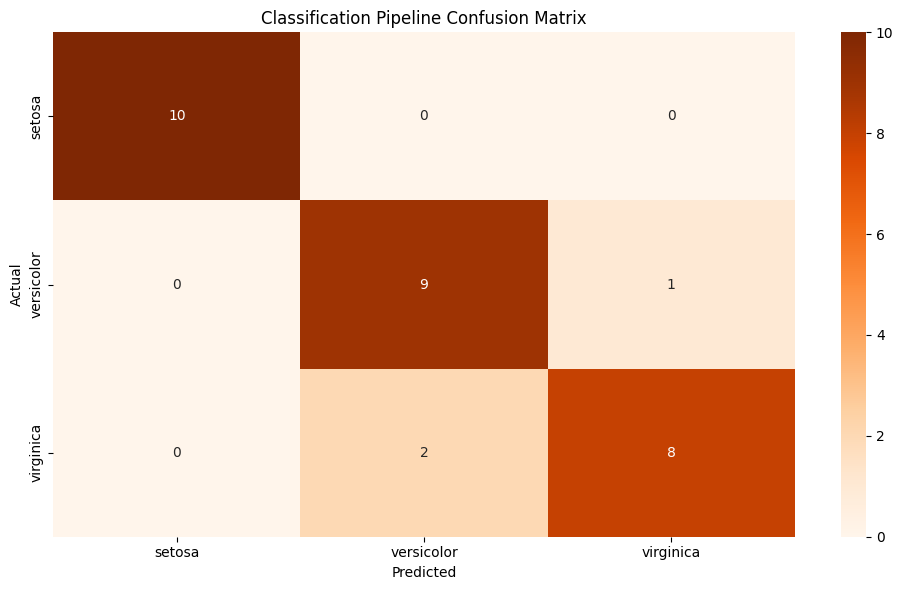

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,6))
sns.heatmap(conf_matrix, annot=True, cmap='Oranges', fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Classification Pipeline Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

The model incorectly classified two viginica irises as versicolor, and one versicolor as virginica. Not bad, only three classification errors out of 30 irises on our first attempt!

## Tune hyperparameters using a pipeline within cross-validation grid search


### Instantiate the pipeline
We'll preprocess the data by scaling it and transforming it onto a to-be-determined number of principle components, follow that up with a KNN model classifier, and combine these estimators into a pipeline. We'll then optimize the pipeline using crossvalidation over a hyperparameter grid search. This will allow us find the best model for the set of trial hyperparamters.


In [19]:
# make a pipeline without specifying any parameters yet
pipeline = Pipeline(
                    [('scaler', StandardScaler()),
                     ('pca', PCA()),
                     ('knn', KNeighborsClassifier()) 
                    ]
                   )

### Define a model parameter grid to search over


In [20]:
# Hyperparameter search grid for numbers of PCA components and KNN neighbors
param_grid = {'pca__n_components': [2, 3],
              'knn__n_neighbors': [3, 5, 7]
             }

### Choose a cross validation method
To ensure the target is stratified, we can use scikit-learn's `StratifiedKFold` cross-validation class.


In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
# Determine the best parameters
best_model = GridSearchCV(estimator=pipeline,
                          param_grid=param_grid,
                          cv=cv,
                          scoring='accuracy',
                          verbose=2
                         )

In [24]:
# Fit the best GridSearchCV model to the training data
best_model.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=5, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=5, pca__n_c

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3, 5, 7],
                         'pca__n_components': [2, 3]},
             scoring='accuracy', verbose=2)

In [25]:
#Evaluate the accuracy of the best model on the test set 
test_score = best_model.score(X_test, y_test)
print(f"{test_score:.3f}")

0.933


We've made a great accuracy improvement from 90% to 93%.


In [26]:
# Display the best parameters
best_model.best_params_

{'knn__n_neighbors': 3, 'pca__n_components': 3}

### Plot the confusion matrix for the predictions on the test set


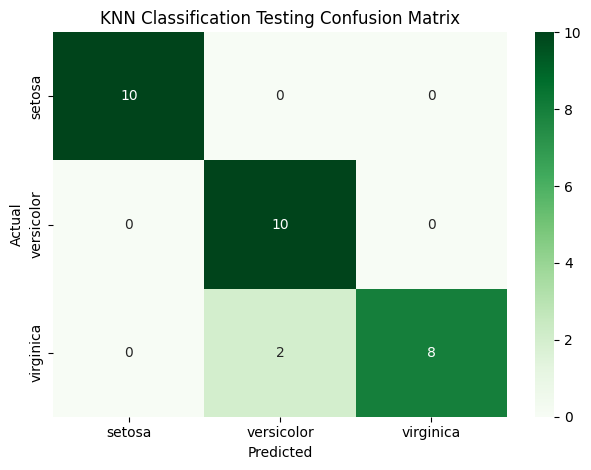

In [31]:
# MAke prediction
y_pred = best_model.predict(X_test)

# Generate the confusion matrix for KNN
conf_matrix = confusion_matrix(y_test,y_pred)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title('KNN Classification Testing Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

Now, only two errors where the predictions were Versicolor but the iris was actually a Virginica.